In [16]:
%matplotlib inline
import time
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from __future__ import print_function # for Python 2/3 compatibility
from matplotlib import animation, rc
from IPython.display import display, HTML

# module Y.X corresponds to file Y/X.py

from scipy import sparse as sparse
import dynamics.time_step as time_step

def col_vec(data):
    vec=np.zeros((data.size,1))
    vec[:,0]=data
    return vec
def row_vec(data):
    vec=np.zeros((1,data.size))
    vec[0,:]=data
    return vec


####################### Horizontal mesh #########################

class Periodic_FD:
    # staggering
    # m0  m1  m2  m3
    #   u0  u1  u2  u3
    def __init__(self, N):
        self.N=N
        ones=np.ones(N);

        right = sparse.spdiags([ones],[0],N,N, format='csr')
        left = sparse.spdiags([ones],[-1],N,N, format='csr')
        left[0,-1]=1
        di = right-left
        mi = .5*(right+left)
        self.di=lambda f:di.dot(f)
        self.mi=lambda f:mi.dot(f)
        self.xi = col_vec(np.linspace(0,N-1,N))-N/2.
        self.onesi = np.ones((N,1))
        self.zeroi = np.zeros((N,1))
       
        right = sparse.spdiags([ones],[1],N,N, format='csr')
        right[-1,0]=1
        left = sparse.spdiags([ones],[0],N,N, format='csr')
        dj = right-left
        mj = .5*(right+left)
        self.dj=lambda f:dj.dot(f)
        self.mj=lambda f:mj.dot(f)
        self.xj = col_vec(np.linspace(0.5,N-.5,N))-N/2.
        self.onesj = np.ones((N,1))
        
        self.onesk = np.ones((1,N))
        self.onesl = np.ones((1,N))
        self.xk = row_vec(np.linspace(0,N-1,N))-N/2.
        self.xl = row_vec(np.linspace(0.5,N-.5,N))-N/2.


    def hstack(self,fields):
        return np.array(np.hstack(fields))
    def up(self,f):
        N=self.N
        return self.hstack( (f[:,N-1:N] , f[:,:-1] ) )
    def down(self,f):
        N=self.N
        return self.hstack( ( f[:,1:] , f[:,0:1] ) )
    def dk(self, fl):
        return fl-self.up(fl)
    def mk(self, fl):
        return .5*(fl+self.up(fl))
    def dl(self, fk):
        return self.down(fk)-fk
    def ml(self, fk):
        return .5*(fk+self.down(fk))


############################ x-y rectangular mesh ##########################

class Rectangle:
    def __init__(self,xmesh,ymesh):
        self.xmesh, self.ymesh = xmesh, ymesh
        self.Nx, self.Ny = xmesh.N, ymesh.N
        self.di, self.dj, self.mi, self.mj = xmesh.di, xmesh.dj, xmesh.mi, xmesh.mj
        self.dk, self.dl, self.mk, self.ml = ymesh.dk, ymesh.dl, xmesh.mk, xmesh.ml
        
        self.xik = xmesh.xi*ymesh.onesk
        self.xjk = xmesh.xj*ymesh.onesk
        self.xil = xmesh.xi*ymesh.onesl
        self.xjl = xmesh.xj*ymesh.onesl
        
        self.yik = xmesh.onesi*ymesh.xk
        self.yil = xmesh.onesi*ymesh.xl
        self.yjk = xmesh.onesj*ymesh.xk
        self.yjl = xmesh.onesj*ymesh.xl
    # double averaging used for Coriolis
    def mjk(self, data):
        return self.mj(self.mk(data))
    def mil(self, data):
        return self.mi(self.ml(data))
    def mjl(self, data):
        return self.mj(self.ml(data))

############################# Grid staggering ###########################

# Due to grid staggering, variable names for fields have a symbolic suffix indicating where the field is known
# In the x direction symbols i and j are used ; i is for cells and j for boundaries between cell
# In the y direction symblos k and l are used ; k is for cells and l for boundaries between cells
# A finite difference operator taking input data on grid i (resp. j,k,l) computes an output on grid j (resp. i,l,k)
# The name of an operator has a suffix indicating on which grid the RESULT is

############################## Wave equation ############################

# convention : eta is the relative deviation of h from its reference value H
# i.e. h'=H.eta and the free surface is at H(1+eta)
# the parameters are g'H and f
 
class Wave:
    def __init__(self, mesh, dx, dy, f, gH=1.):
        self.mesh = mesh
        self.dx,self.dy = dx,dy
        self.gH, self.f = gH, f
    def eval_flow(self, fun):
        dx, dy, mesh = self.dx, self.dy, self.mesh
        eta_ik, junk, junk = fun(dx*mesh.xik,dy*mesh.yik)
        junk, u_jk, junk   = fun(dx*mesh.xjk,dy*mesh.yjk)
        junk, junk, v_il   = fun(dx*mesh.xil,dy*mesh.yil)
        return eta_ik,u_jk,v_il
    def diagnose(self,flow): # returns data to be plotted
        dx, dy, mesh = self.dx, self.dy, self.mesh
        h_ik, u_jk, v_il = flow
        zeta_jl = mesh.dj(v_il)/dx - mesh.dl(u_jk)/dy
        return (dx*mesh.xik, dy*mesh.yik,
                h_ik, mesh.mi(u_jk), mesh.mk(v_il), mesh.mi(mesh.mk(zeta_jl)) )
    def curl_jl(self, u_jk, v_il):
        dx,dy,mesh = self.dx, self.dy, self.mesh
        di,dj,dk,dl = mesh.di, mesh.dj, mesh.dk, mesh.dl
        zeta_jl = dj(v_il)/dx - dl(u_jk)/dy
        return zeta_jl
    def bwd_fast_slow(self, flow, tau):
        h_ik, u_jk, v_il = flow
        dflow = self.equation(*flow)
        return ( flow, (0.,0.,0.), dflow )
    def equation(self, eta_ik, u_jk, v_il):
        dx,dy,mesh,f,gH = self.dx, self.dy, self.mesh, self.f, self.gH
        di,dj,dk,dl,mjk,mil = mesh.di, mesh.dj, mesh.dk, mesh.dl, mesh.mjk, mesh.mil
        # dh/dt + du/dx + dv/dy = 0
        deta_ik = - di(u_jk)/dx-dk(v_il)/dy
        # du/dt - fv + gH.dh/dx = 0
        du_jk =  f*mesh.mjk(v_il) - (gH/dx)*dj(eta_ik)
        # dv/dt + fu + gH.dh/dy = 0
        dv_il = -f*mesh.mil(u_jk) - (gH/dy)*dl(eta_ik) 
        return deta_ik, du_jk, dv_il

############################## Shallow-water equations ############################

# convention : eta is now g'h
# the only parameter is f

# Enstrophy-conserving scheme from Sadourny (1975)
# "The Dynamics of Finite-Difference Models of Shallow-Water Equations"

class SaintVenant(Wave):
    def equation(self, gh_ik, u_jk, v_il):
        dx,dy,mesh,f,gH = self.dx, self.dy, self.mesh, self.f, self.gH
        di,dj,dk,dl = mesh.di, mesh.dj, mesh.dk, mesh.dl   # finite-difference operators
        mi,mj,mk,ml = mesh.mi, mesh.mj, mesh.mk, mesh.ml   # averaging operators
        # dh/dt + d/dx(hu) + d/dy(hv) = 0
        U_jk = mj(gh_ik)*u_jk
        V_il = ml(gh_ik)*v_il
        dgh_ik = - di(U_jk)/dx-dk(V_il)/dy
        # B = gH + (u^2+v^2)/2
        B_ik = mi(u_jk*u_jk) + mk(v_il*v_il)
        B_ik = gh_ik + .5*B_ik
        # zeta = dv/dx-du/dy, q = (zeta+f)/gh
        zeta_jl = dj(v_il)/dx-dl(u_jk)/dy
        q_jl = (zeta_jl+f)/mesh.mjl(gh_ik)
        q_il, q_jk = mi(q_jl), mk(q_jl)
        # du/dt - qV + dB/dx = 0
        du_jk =  q_jk*mesh.mjk(V_il) - dj(B_ik)/dx
        # dv/dt + qU + dB/dy = 0
        dv_il = -q_il*mesh.mil(U_jk) - dl(B_ik)/dy 
        return dgh_ik, du_jk, dv_il

############################## Quasi-geostrophic equations ############################

class Solver:
    def __init__(self, mesh, op): # op is any constant-coefficient, s.p.d operator
        dirac = 0.*mesh.xik
        dirac[0,0] = 1.
        op_fourier = np.fft.fft2(op(dirac)) # Fourier representation of operator
        self.op = 1./op_fourier # Fourier representation of inverse operator
    def __call__(self, rhs): # solve op(x)=rhs
        rhs_hat = np.fft.fft2(rhs)
        lhs_hat = rhs_hat*self.op
        lhs = np.fft.ifft2(lhs_hat)
        return lhs.real

# the only parameter is Rd

class QuasiGeostrophic(Wave):
    def __init__(self, mesh, dx, dy, f, gH):
        self.mesh, self.f, self.gH = mesh, f, gH
        self.dx,self.dy, self.Rd_m2 = dx,dy, f*f/gH
        self.psi = Solver(mesh,self.pv)
    def eval_flow(self, fun):
        dx, dy, mesh, f, gH = self.dx, self.dy, self.mesh, self.f, self.gH
        di,dj,dk,dl = mesh.di, mesh.dj, mesh.dk, mesh.dl
        gh_jl, junk, junk  = fun(dx*mesh.xjl,dy*mesh.yjl)
        junk, u_jk, junk   = fun(dx*mesh.xjk,dy*mesh.yjk)
        junk, junk, v_il   = fun(dx*mesh.xil,dy*mesh.yil)
        zeta_jl = dj(v_il)/dx-dl(u_jk)/dy
        pv_jl = gH*(f+zeta_jl)/gh_jl - f
        return (pv_jl,)
    def diagnose(self,flow): # returns data to be plotted
        dx, dy, mesh = self.dx, self.dy, self.mesh
        di,dj,dk,dl = mesh.di, mesh.dj, mesh.dk, mesh.dl
        mi,mj,mk,ml = mesh.mi, mesh.mj, mesh.mk, mesh.ml
        pv_jl, = flow
        psi_jl = self.psi(pv_jl)
        u_jk = -dk(psi_jl)/dy
        v_il = di(psi_jl)/dx
        zeta_jl = dj(v_il)/dx-dl(u_jk)/dy
        return dx*mesh.xjl, dy*mesh.yjl, psi_jl, ml(u_jk), mj(v_il), zeta_jl, pv_jl
    
    def pv(self,psi_jl): # computes pv given psi
        dx,dy,mesh,Rd_m2 = self.dx, self.dy, self.mesh, self.Rd_m2
        di,dj,dk,dl = mesh.di, mesh.dj, mesh.dk, mesh.dl   # finite-difference operators
        # convention : u=-dpsi/dy v=dpsi/dx 
        # pv = (zeta-Rd^-2 psi)
        u_jk = -dk(psi_jl)/dy
        v_il = di(psi_jl)/dx
        zeta_jl = dj(v_il)/dx-dl(u_jk)/dy
        pv_jl = zeta_jl-Rd_m2*psi_jl
        return pv_jl
    def bwd_fast_slow(self, flow, tau):
        dflow = self.equation(*flow)
        return ( flow, (0.,), (dflow,) )
    def equation(self, pv_jl):
        dx,dy,mesh = self.dx, self.dy, self.mesh
        mi,dj,mk,dl = mesh.mi, mesh.dj, mesh.mk, mesh.dl
        # find psi given pv
        psi_jl = self.psi(pv_jl)
        # transport equation for pv :
        # dpv/dt = -u.dpv/dx -v.dpv.dy = J(pv,psi)
        # J(a,b) = (da/dx)(db/dy)-(da/dy)(db/dx) 
        #        = d/dx(a*db/dy)-d/dy(a*db/dx)
        #        = K(a,b)-K(b,a)
        # Arakawa Jacobian, see Eqs (8.14-8.16) in
        # https://ocw.mit.edu/courses/earth-atmospheric-and-planetary-sciences/12-950-atmospheric-and-oceanic-modeling-spring-2004/lecture-notes/lec12.pdf
        def ddx(a): return dj(mi(a)) # d/dx
        def ddy(a): return dl(mk(a)) # d/dy
        def KK(a,dadx,b,dbdy): return dadx*dbdy + ddx(a*dbdy) + ddy(b*dadx)
        def K(a,b): return KK(a,ddx(a),b,ddy(b)) # avoids computing da/dx, db/dy twice
        return (K(pv_jl,psi_jl)-K(psi_jl,pv_jl))/(3.*dx*dy)

##################### Run the model and create animation ##########################

# see http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

class TimeSequence:
    def __init__(self, mesh, model, scheme, Nstep, flow0, ax):
        self.mesh, self.model, self.scheme =  mesh, model, scheme
        self.Nstep, self.flow0, self.ax = Nstep, flow0, ax
    def draw(self, flow, i):
        self.flow = flow
        self.ax.clear()
        diags=self.model.diagnose(flow)
        my_figure(self.ax, i*Texp, *diags)
    def start(self):
        self.flow = self.flow0
        self.time = time.time()
        return (self.ax,) # this function must return a tuple, do not remove comma
    def animate(self,i):
        scheme, flow = self.scheme, self.flow
        self.draw(flow, i)
        for ii in range(self.Nstep):
            flow = scheme.next(flow)
        self.flow = flow
        dtime = time.time()-self.time
        if dtime>3.:
            print('Frame %d/%d'%(i,Nexp))
            self.time = self.time + dtime
        return (self.ax,)

def experiment(Model, max_speed, Nx=128, Ny=128, courant=0.5, fps=5, filename=None, ):
    dx, dy = Lx/Nx, Ly/Ny
    dt = courant*dx/max_speed

    xmesh = Periodic_FD(Nx)
    ymesh = Periodic_FD(Ny)
    mesh = Rectangle(xmesh,ymesh)

    model = Model(mesh,dx,dy,f,gH)
    Nstep = int((1.*Texp)/dt+1.)
    dt = (1.*Texp)/Nstep
    scheme = time_step.ARK2(model.bwd_fast_slow, dt)

    flow = model.eval_flow(initial_condition)

    if filename is None:
        for j in range(Nexp):
            for i in range(Nstep): flow = scheme.next(flow)
            plt.figure(figsize=(5,5))
            diags=model.diagnose(flow)
            my_figure(plt, j*Texp, *diags)
#            eta_ik, u_jk, v_il = flow
#            zeta_jl = mesh.dj(v_il)/dx - mesh.dl(u_jk)/dy
#            my_figure(plt, mesh.xik*dx, mesh.yik*dy, j*Texp,
#                      eta_ik, mesh.mi(u_jk), mesh.mk(v_il),
#                      mesh.mi(mesh.mk(zeta_jl)) )
            plt.show()
            plt.close()
    else:
        fig=plt.figure(figsize=(5,5))
        seq = TimeSequence(mesh, model, scheme, Nstep, flow, plt.gca())
        anim = animation.FuncAnimation(fig,seq.animate, Nexp, 
                                       init_func=seq.start,
                                       interval=1e3/fps,blit=False )
        anim.save(filename, codec='h264')

def show_movie(filename, width=400):
    return HTML('<video width=%d controls><source src="%s" type="video/mp4"></video>'%(width,filename) )

t=0.000000, vmax=0.017304 -0.108003710211 0.113984867053


t=20.000000, vmax=0.017712 -0.108284137525 0.114207213956
t=40.000000, vmax=0.018027 -0.108239268823 0.114020557438


t=60.000000, vmax=0.018237 -0.107688084855 0.113208041493
t=80.000000, vmax=0.018288 -0.107880483539 0.114381688987


t=100.000000, vmax=0.018118 -0.108698807201 0.114715876478
t=120.000000, vmax=0.017901 -0.108344712778 0.114628870194


t=140.000000, vmax=0.017509 -0.108675637383 0.114309226423
t=160.000000, vmax=0.017135 -0.108509370815 0.114628316441


t=180.000000, vmax=0.016835 -0.108366838405 0.114388533755
t=200.000000, vmax=0.016515 -0.107959019642 0.114511389359


t=220.000000, vmax=0.016402 -0.108142039178 0.114973759797
t=240.000000, vmax=0.016449 -0.108667650457 0.114884587716


t=260.000000, vmax=0.016582 -0.10931874642 0.114805126322
t=280.000000, vmax=0.016849 -0.10871793199 0.114660715746


t=300.000000, vmax=0.016788 -0.109167371171 0.11414205323
t=320.000000, vmax=0.016842 -0.110134733393 0.114877561722


t=340.000000, vmax=0.016809 -0.111264271823 0.116462005439
t=360.000000, vmax=0.016996 -0.11170509578 0.116918739874


t=380.000000, vmax=0.017155 -0.110574159178 0.116688857111
Frame 19/100
t=400.000000, vmax=0.017268 -0.110251116934 0.116561472779


t=420.000000, vmax=0.017324 -0.110477418044 0.117571548011
t=440.000000, vmax=0.017325 -0.111656510489 0.116769073362


t=460.000000, vmax=0.017269 -0.112472065693 0.116533302997
t=480.000000, vmax=0.017269 -0.111311373863 0.115620386119


t=500.000000, vmax=0.017161 -0.109707612113 0.11514986572


t=520.000000, vmax=0.016958 -0.10899100296 0.115585022297
t=540.000000, vmax=0.016734 -0.110796810785 0.11750033101


t=560.000000, vmax=0.016617 -0.111777784477 0.118759167694


t=580.000000, vmax=0.016558 -0.111737425239 0.118122075801
t=600.000000, vmax=0.016511 -0.110839104475 0.118033155457


t=620.000000, vmax=0.016474 -0.11100488974 0.118799342492
t=640.000000, vmax=0.016508 -0.112734512827 0.119027885988


t=660.000000, vmax=0.016517 -0.113619006113 0.118855059878
t=680.000000, vmax=0.016709 -0.114110843495 0.118474803058


t=700.000000, vmax=0.016880 -0.113728463505 0.117390094637
t=720.000000, vmax=0.017026 -0.112262463682 0.117369472984


t=740.000000, vmax=0.017270 -0.110961122443 0.118022449286
Frame 37/100


t=760.000000, vmax=0.017495 -0.108946257819 0.118204881423
t=780.000000, vmax=0.017601 -0.110298080428 0.117858682818


t=800.000000, vmax=0.017596 -0.110374500676 0.116547329052
t=820.000000, vmax=0.017655 -0.108876775366 0.113671239547


t=840.000000, vmax=0.017670 -0.107123126914 0.115075363885
t=860.000000, vmax=0.017631 -0.107528893467 0.114453291716


t=880.000000, vmax=0.017615 -0.109277496588 0.11342981438
t=900.000000, vmax=0.017652 -0.110202949659 0.114607911553


t=920.000000, vmax=0.017679 -0.111729371084 0.115678226115


t=940.000000, vmax=0.017724 -0.112084534157 0.115600424507
t=960.000000, vmax=0.017932 -0.112610069777 0.114867508621


t=980.000000, vmax=0.018130 -0.112471589053 0.113701250945
t=1000.000000, vmax=0.018274 -0.110929615375 0.112525320657


t=1020.000000, vmax=0.018490 -0.108551206783 0.111560368646
t=1040.000000, vmax=0.018546 -0.107163825186 0.111292165857


t=1060.000000, vmax=0.018669 -0.10897390168 0.111243385707
t=1080.000000, vmax=0.018687 -0.109262017214 0.11320043428


t=1100.000000, vmax=0.018659 -0.109867342812 0.113722566911
Frame 55/100
t=1120.000000, vmax=0.018704 -0.109970631232 0.113703606258


t=1140.000000, vmax=0.018574 -0.110883208812 0.113812105707
t=1160.000000, vmax=0.018286 -0.111800192045 0.113497796664


t=1180.000000, vmax=0.018074 -0.111646446133 0.112591939023
t=1200.000000, vmax=0.017873 -0.110718319477 0.111968520448


t=1220.000000, vmax=0.017760 -0.111115563939 0.112015502895
t=1240.000000, vmax=0.017690 -0.110591129533 0.112540145309


t=1260.000000, vmax=0.017762 -0.108998962686 0.112130471943
t=1280.000000, vmax=0.017757 -0.108651422067 0.114511706416


t=1300.000000, vmax=0.017908 -0.108830628 0.114718472738
t=1320.000000, vmax=0.017940 -0.110829005364 0.115428354482


t=1340.000000, vmax=0.017909 -0.113143843477 0.115733313665
t=1360.000000, vmax=0.018008 -0.1131945612 0.114676995239


t=1380.000000, vmax=0.018048 -0.117168060424 0.115465815007
t=1400.000000, vmax=0.018187 -0.117541749077 0.115218829887


t=1420.000000, vmax=0.018216 -0.11703925265 0.115077932003
t=1440.000000, vmax=0.018105 -0.116332611976 0.11584006749


t=1460.000000, vmax=0.018108 -0.115440200388 0.115603295602
Frame 73/100
t=1480.000000, vmax=0.018002 -0.115652035379 0.115600998581


t=1500.000000, vmax=0.018104 -0.11842047236 0.116219593538


t=1520.000000, vmax=0.018009 -0.11924910063 0.116328859424
t=1540.000000, vmax=0.017933 -0.117682622002 0.116606501065


t=1560.000000, vmax=0.017827 -0.116591307029 0.117768620743


t=1580.000000, vmax=0.017689 -0.116297782035 0.117759944684
t=1600.000000, vmax=0.017555 -0.121120095264 0.117627452926


t=1620.000000, vmax=0.017574 -0.120948323767 0.119243576384


t=1640.000000, vmax=0.017532 -0.121168987307 0.118874998247
t=1660.000000, vmax=0.017447 -0.116638614079 0.11929322378


t=1680.000000, vmax=0.017503 -0.116784633689 0.118852192089
t=1700.000000, vmax=0.017495 -0.118637674273 0.118598784651


t=1720.000000, vmax=0.017540 -0.121448630619 0.116958247249
t=1740.000000, vmax=0.017636 -0.123846092896 0.115988489543


t=1760.000000, vmax=0.017790 -0.122797476863 0.115289918949


t=1780.000000, vmax=0.017748 -0.124798221807 0.114761166417


t=1800.000000, vmax=0.017810 -0.122559039689 0.113485872699
Frame 90/100
t=1820.000000, vmax=0.017806 -0.121823560236 0.114169769231


t=1840.000000, vmax=0.017696 -0.117936096499 0.115065132559


t=1860.000000, vmax=0.017533 -0.116322729546 0.113503121846
t=1880.000000, vmax=0.017520 -0.116859205871 0.113274711329


t=1900.000000, vmax=0.017477 -0.112819525037 0.112743000581


t=1920.000000, vmax=0.017461 -0.114606501577 0.112585706217
t=1940.000000, vmax=0.017546 -0.114870957616 0.112986751115


t=1960.000000, vmax=0.017610 -0.108420004398 0.112708660444
t=1980.000000, vmax=0.017807 -0.110950171096 0.112687598517


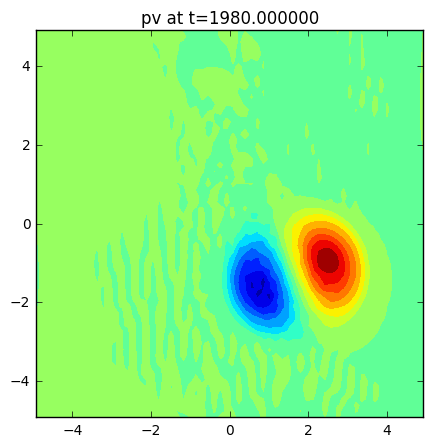

In [20]:
f=1.          # Coriolis parameter
Nexp=100      # number of frames in movie
Texp=20        # time interval between two movie frames
varname='pv'  # quantity shown in the plot : choose among 'gh', 'gh-gh0', 'zeta', 'pv', 'ke', 'u', 'v'

#----------------------------------------------------------------

Lx,Ly,gH = 10.,10.,1. # Domain size

def modon(x,y):
    x1, x2 = x+0.5, x-0.5
    gh1 = .05*np.exp(-.5*(x1**2+y**2))
    gh2 = .05*np.exp(-.5*(x2**2+y**2))
    gh = gh1-gh2
    u   = y*gh    # u = -dpsi/dy
    v1  = -x1*gh1 # v=dpsi/dx
    v2  = -x2*gh2 # v=dpsi/dx
    v   = v1-v2
    return gH*(1.+gh), (gH/f)*u, (gH/f)*v

def figure_SV(ax,t, x,y,gh,u,v,zeta):
    gh0, u0, v0 = initial_condition(x,y)
    var = {'gh':gh, 'gh-gh0':gh-gh0, 'zeta':zeta, 'pv':(f+zeta)/gh,
           'ke':.5*(u*u+v*v), 'u':u, 'v':v}[varname]
    ax.contourf(x,y,var,20)
    plt.title('%s at t=%f'%(varname,t))
    print('t=%f, vmax=%f'%(t,u.max()), var.min(), var.max())

def figure_QG(ax,t, x,y,psi,u,v,zeta,pv):
    var = {'pv':pv}[varname]
    ax.contourf(x,y,var,20)
    plt.title('%s at t=%f'%(varname,t))
    print('t=%f, vmax=%f'%(t,u.max()), var.min(), var.max())

initial_condition, my_figure = modon, figure_QG
experiment(QuasiGeostrophic, .02, Nx=64, Ny=64, filename='QG.mp4')
show_movie('QG.mp4')


t=0.000000, vmax=0.016752 0.893334579162 1.11273026919


t=20.000000, vmax=0.017137 0.893236514191 1.11284767848


t=40.000000, vmax=0.017371 0.892936329861 1.11311464615


t=60.000000, vmax=0.017549 0.892650345269 1.11341450539


t=80.000000, vmax=0.017655 0.892735653685 1.11341118813


Frame 4/100
t=100.000000, vmax=0.017434 0.893651168357 1.1126398883


t=120.000000, vmax=0.017016 0.892825385469 1.11290005553


t=140.000000, vmax=0.016532 0.892970062994 1.11283007026


t=160.000000, vmax=0.016224 0.893687091475 1.11241355576


t=180.000000, vmax=0.016185 0.893310947774 1.1127223222


Frame 9/100
t=200.000000, vmax=0.016877 0.89263664212 1.11346150907


t=220.000000, vmax=0.017351 0.892182885637 1.11402777118


t=240.000000, vmax=0.017781 0.892140990906 1.11438095998


t=260.000000, vmax=0.017892 0.892394350759 1.11432460149


Frame 13/100
t=280.000000, vmax=0.018048 0.892718850238 1.11444917138


t=300.000000, vmax=0.017995 0.893398190757 1.11392871246


t=320.000000, vmax=0.017783 0.893973407123 1.11326472647


t=340.000000, vmax=0.017613 0.894033541734 1.11276603114


Frame 17/100
t=360.000000, vmax=0.017311 0.892746295153 1.11214910415


t=380.000000, vmax=0.017161 0.891559093329 1.11301059184


t=400.000000, vmax=0.016993 0.890855233433 1.11370102316


t=420.000000, vmax=0.016801 0.890972070492 1.11384637992


t=440.000000, vmax=0.016595 0.89175642587 1.11397090644


Frame 22/100
t=460.000000, vmax=0.016661 0.892586677567 1.11366379328


t=480.000000, vmax=0.016638 0.892831441386 1.11232284475


t=500.000000, vmax=0.016523 0.892280290199 1.11259396656


t=520.000000, vmax=0.016417 0.891216488174 1.11360627976


Frame 26/100
t=540.000000, vmax=0.016590 0.890188847218 1.11516025169


t=560.000000, vmax=0.016790 0.889822310719 1.11634970572


t=580.000000, vmax=0.016739 0.890633119071 1.11671640106


t=600.000000, vmax=0.016700 0.891840538384 1.11602102947


Frame 30/100


t=620.000000, vmax=0.016510 0.891993054179 1.11586575278


t=640.000000, vmax=0.016359 0.891901507493 1.11552410675


t=660.000000, vmax=0.016240 0.89077897929 1.11507241543


t=680.000000, vmax=0.016225 0.890384626799 1.11520351149


Frame 34/100
t=700.000000, vmax=0.016428 0.891142684026 1.11449609394


t=720.000000, vmax=0.016666 0.892404277437 1.11397506179


t=740.000000, vmax=0.016645 0.89346619833 1.11325860853


t=760.000000, vmax=0.016605 0.894036047949 1.11390314028


t=780.000000, vmax=0.016627 0.893310215933 1.11410107275


Frame 39/100


t=800.000000, vmax=0.016653 0.892815135794 1.11358964517


t=820.000000, vmax=0.016744 0.892823140701 1.11390011672


t=840.000000, vmax=0.016769 0.893577300611 1.11462082249


t=860.000000, vmax=0.016935 0.893731380877 1.11499257606


Frame 43/100
t=880.000000, vmax=0.017006 0.893682269516 1.11494106074


t=900.000000, vmax=0.016969 0.893236391259 1.11485604346


t=920.000000, vmax=0.016703 0.893986474132 1.11573569613


t=940.000000, vmax=0.016725 0.894235703242 1.11567784946


t=960.000000, vmax=0.016641 0.894158272127 1.11469503697


Frame 48/100
t=980.000000, vmax=0.016765 0.894236221459 1.11485887391


t=1000.000000, vmax=0.016749 0.894418563986 1.11475334528


t=1020.000000, vmax=0.016695 0.894533223502 1.1148240888


t=1040.000000, vmax=0.016625 0.89439152724 1.11499565483


t=1060.000000, vmax=0.016574 0.894156256359 1.11472818233


Frame 53/100
t=1080.000000, vmax=0.016695 0.893617767116 1.11501253279


t=1100.000000, vmax=0.016985 0.893457698886 1.11499559616


t=1120.000000, vmax=0.017178 0.893159710602 1.11409884429


t=1140.000000, vmax=0.017396 0.893343913491 1.11459948388


t=1160.000000, vmax=0.017520 0.893068465392 1.11440891395


Frame 58/100
t=1180.000000, vmax=0.017571 0.892430153234 1.11479673968


t=1200.000000, vmax=0.017618 0.892058069096 1.11525660435


t=1220.000000, vmax=0.017560 0.892266971461 1.11515450626


t=1240.000000, vmax=0.017278 0.893511536955 1.11489998998


t=1260.000000, vmax=0.017078 0.892426128895 1.1149313466


Frame 63/100
t=1280.000000, vmax=0.016733 0.89187971976 1.11560863986


t=1300.000000, vmax=0.016763 0.891043840587 1.11608248466


t=1320.000000, vmax=0.016951 0.890665877932 1.11568943366


t=1340.000000, vmax=0.017033 0.890414596074 1.1166403465


t=1360.000000, vmax=0.016931 0.889484885467 1.11667483288


t=1380.000000, vmax=0.016857 0.889993117041 1.1165885431


Frame 69/100
t=1400.000000, vmax=0.016919 0.890375554933 1.11748921962


t=1420.000000, vmax=0.016774 0.889583695243 1.11662346424


t=1440.000000, vmax=0.017172 0.890319621953 1.11733166387


t=1460.000000, vmax=0.017232 0.891801206332 1.11560724579


t=1480.000000, vmax=0.017407 0.891898804972 1.11557150782


t=1500.000000, vmax=0.017517 0.891015364769 1.11532493066


Frame 75/100
t=1520.000000, vmax=0.017474 0.890249488938 1.11349441224


t=1540.000000, vmax=0.017530 0.890594347362 1.11393745139


t=1560.000000, vmax=0.017638 0.890503687364 1.11446903688


t=1580.000000, vmax=0.017484 0.890859238971 1.1149108153


t=1600.000000, vmax=0.017382 0.891639791732 1.11645543048


t=1620.000000, vmax=0.017118 0.891294190261 1.1159413878


Frame 81/100
t=1640.000000, vmax=0.016912 0.891525164627 1.11624870585


t=1660.000000, vmax=0.016942 0.8919939624 1.11520117544


t=1680.000000, vmax=0.016994 0.892232421555 1.11616106426


t=1700.000000, vmax=0.017019 0.891527511473 1.11622301904


t=1720.000000, vmax=0.016843 0.891555026258 1.11612944986


Frame 86/100
t=1740.000000, vmax=0.016977 0.891223142138 1.11608240548


t=1760.000000, vmax=0.017150 0.891349327652 1.11636643533


t=1780.000000, vmax=0.017143 0.892851230506 1.11657975661


t=1800.000000, vmax=0.017077 0.89360506475 1.11742993079


t=1820.000000, vmax=0.017124 0.892890293832 1.11790524421


Frame 91/100
t=1840.000000, vmax=0.017210 0.893525507212 1.11710808233


t=1860.000000, vmax=0.017343 0.893480496099 1.11631585617


t=1880.000000, vmax=0.017304 0.892437184017 1.11648760428


t=1900.000000, vmax=0.016940 0.892679009687 1.11632037156


t=1920.000000, vmax=0.016940 0.893309200281 1.11618722045


Frame 96/100
t=1940.000000, vmax=0.017007 0.894061312704 1.11669049369


t=1960.000000, vmax=0.017069 0.894842884534 1.11645087892


t=1980.000000, vmax=0.016960 0.895552557206 1.11553592406


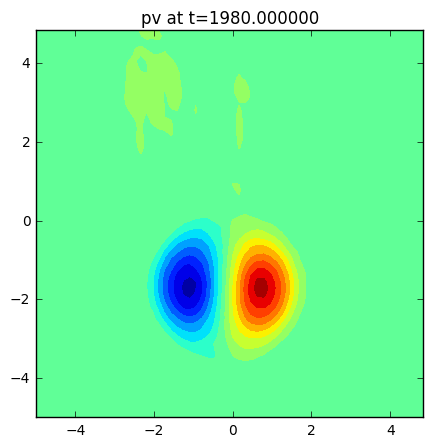

In [21]:
initial_condition, my_figure = modon, figure_SV
experiment(SaintVenant, np.sqrt(gH), Nx=64, Ny=64, filename='SaintVenant.mp4')
show_movie('SaintVenant.mp4')